In [1]:
def delay(delay_msec = 100):
    dieTime = QtCore.QTime.currentTime().addMSecs(delay_msec)
    while (QtCore.QTime.currentTime() < dieTime):
        QtCore.QCoreApplication.processEvents(QtCore.QEventLoop.AllEvents, 100)


In [2]:
from time import sleep

In [3]:
def flip_powermirror():
    pulser.set_channel_off(['ch5'])
    pulser.set_channel_on(['ch5'])

In [133]:
flip_powermirror()

In [82]:
ello_flip.move_pos_1()

saving spectra
saving spectra
saving spectra
saving spectra
step
step
Stopping (step).
poi
Stopping(poi).
False 0
step
step
step
Stopping (step).
step
poi
Stopping(poi).
False 0
saving spectra
saving spectra
saving spectra
saving spectra
step
step
Stopping (step).
poi
Stopping(poi).
False 0
saving spectra
saving spectra
saving spectra
saving spectra
step
step
Stopping (step).
poi
Stopping(poi).
False 0


In [6]:
ello_flip.move_pos_3()

In [36]:
pulser.set_channel_on(['ch6'])

In [132]:
powermeter.get_power() * 1e6

688.046683

In [7]:
bin_width = int(1e12/50)
n_vals = 300
def calibrate(steps = [240, 280, 300, 320, 360]):
    calibration = {}
    for step in steps:
        motor_pi3.moveToAbsolutePosition(motor=0, pos=step)
        delay(2000)
        flip_powermirror()
        delay(2000)
        for i in range(2):
            try:
                pwr = powermeter.get_power() * 1e6
            except:
                pass
            delay(200)
        flip_powermirror()
        calibration.update({step:pwr})
    return calibration

In [22]:
motor_pi3.moveToAbsolutePosition(motor=0, pos=310)

In [35]:
save_folder0 = r"C:\Data\2022\197_qudi\ref_40nm"

In [31]:
calibration = calibrate()
motor_pi3.moveToAbsolutePosition(motor=0, pos=310)
import json
import os
with open(os.path.join(save_folder0, "calibration.txt"), 'w') as file:
     file.write(json.dumps(calibration)) # use `json.loads` to do the reverse

In [140]:
import os
import time
import datetime
from qtpy import QtCore
import numpy as np
from core.connector import Connector
from core.configoption import ConfigOption
from logic.generic_logic import GenericLogic


class Automatedmeasurements(QtCore.QThread):
    """ How to use this thing:
        1. create pois with poimanager (Qudi)
        2. create instance of class
        3. specify steps with "init_steps()"
        4. start with "start()"
            4.1 stop with "stop()"
        If pois have changed since class was initiated, update pois with "init_pois()"
            
        How to add new steps:
        1. write function that starts what you want to do (e.g. take a spectrum)
        2. add it to the func_dict in __init__()
        3. look for the signal that gets emitted once the step is done or create it yourself
        4. connect it to _next_step() in __init__()
    """
    # declare connectors
#     scannerlogic = Connector(interface='ConfocalLogic')
#     spectrumlogic = Connector(interface='SpectrumLogic')
#     optimizerlogic = Connector(interface = 'OptimizerLogic')
#     nicard = Connector(interface='NationalInstrumentsXSeries', optional=True)
#     ello_flipp = Connector(interface='ThorlabsElloFlipper', optional=True)
#     steps = ConfigOption('steps', missing='warn')
    # internal signals

    sigNextPoi = QtCore.Signal()
    sigNextStep = QtCore.Signal()
    sigStepDone = QtCore.Signal()
    abort = False
    steps = ['move', 'optimize', 'spectrum']#, 'time_trace']
    steps_bg = ['move', 'spectrum']#, 'time_trace']
    def __init__(self):
        super().__init__()

        self.func_dict = {
            'move' : self.move_to_poi,
            'optimize' : self.optimize_on_poi,
            'spectrum' : self.take_spectrum,
            'time_trace' : self.measure_time_trace
        }
        self.on_activate()
    def on_activate(self):
        """ Initialisation performed during activation of the module.
        """
 
        self._spectrumlogic = spectrumlogic
        self._scannerlogic = scannerlogic
        self._optimizerlogic = optimizerlogic
        # self._poimanagerlogic = self.poimanagerlogic()
        # self._save_logic = self.savelogic()
        self._ello_flipper = ello_flip
#         if self.ello_devices():
#             self._ello_rotor = self.ello_devices().ello_rotor
        # self._cwave = self.cwavelaser()
        # self.sig_cwave_shutter.connect(self._cwave.set_shutters_states)

        # self._nicard = self.nicard()
        self.save_folder = save_folder0
        
        ## signals
        # connect internal signals
        self.sigNextPoi.connect(self._next_poi, QtCore.Qt.QueuedConnection)
        self.sigNextStep.connect(self._next_step,QtCore.Qt.QueuedConnection )
        # connect signals that mark the completion of one step
        self.sigStepDone.connect(self._next_step,QtCore.Qt.QueuedConnection )
        spectrumlogic.sig_specdata_taken.connect(self.save_spectra, QtCore.Qt.QueuedConnection)
        #spectrumlogic.sig_specdata_updated.connect(self._next_step)
        
        self._optimizerlogic._sigFinishedAllOptimizationSteps.connect(self._next_step, QtCore.Qt.QueuedConnection)

        ## initialisation of variables
        self.angles_for_pol_dep_spec = np.linspace(0,360,3) # TODO: change num to 100
    
    def on_deactivate(self):
        pass

    def start(self):
        """Starts the measurements"""
        self.abort = False
        self.init_pois()
        self.sigNextPoi.emit()
        return
    
    
    def stop(self):
        """Stops the program"""
        self.abort = True
        return
    
    
    def init_pois(self,poi_names=None):
        if poi_names==None:
            self.poi_names = list((np.arange(len(self._scannerlogic.pois)) + 1).astype(str))#self._poimanagerlogic.poi_names
        else:
            self.poi_names = poi_names
        # copy the names into an array that we can modify
        self._poi_names = list(self.poi_names).copy() # shallow copy
        # get positions of the pois (dict)
        pois = self._scannerlogic.pois
        texts = (np.arange(len(self._scannerlogic.pois)) + 1).astype(str)
        self.poi_positions = {t: pos for t, pos in zip(texts, pois)} #self._poimanagerlogic.poi_positions
        
        return
    
    
    def init_steps(self,steps):
        """Stores the steps as class object."""
        keys = self.func_dict.keys()
        if not set(steps).issubset(set(keys)):
            raise Exception('The following steps are not listed in the func_dict: %s'% (list(set(steps) - set(keys))))
#         self.steps = self.steps
        return
    
    
    def _next_poi(self):
        """Iterates through the pois.
        
        Sets the next poi to be the active one and starts the measurements on this one."""
        
        print('poi')
        # Stop program if finished or user wants to stop
        if self.abort or (len(self._poi_names)==0):
            print('Stopping(poi).')
            print(self.abort,len(self._poi_names))
            return
        # Choose the first poi in the list, set it as the current one and delete it.
        self._current_poi_name = self._poi_names.pop(0)
        print('Current poi %s'%self._current_poi_name)
        # updates the position of the current poi
        self._current_poi_position = self.poi_positions[self._current_poi_name]
        
        # copy the steps into an array that we can modify
        if self._current_poi_name != '1':
            self._steps = self.steps.copy() #shallow copy
        else:
            self._steps = self.steps_bg.copy()
        print(self._steps)
#         os.mkdir(os.path.join(save_folder0, self._current_poi_name))
#         self.save_folder = os.path.join(save_folder0, self._current_poi_name)
        # start the steps
        self.sigNextStep.emit()
        return
    
    def _next_step(self):
        """Iterates through the steps."""
        print('step')
        if self.abort:
            print('Stopping (step).')
            return
        if len(self._steps)==0:
            # all steps for the current poi are done, go to next poi
            self.sigNextPoi.emit()
            return
        # choose next step in list as current one and remove it
        self._current_step = self._steps.pop(0)
        print('Current step: %s'%self._current_step)
        print('_steps', self._steps)
        print('steps', self.steps)
        #run the step
        self.func_dict[self._current_step]()
        return
    
    
    def move_to_poi(self,poi_name=None,rs=1000):
        """Moves to the current poi"""
        print('move')
        if poi_name==None:
            poi_name = self._current_poi_name
            poi_position = self._current_poi_position
        else:
            poi_position = self.poi_positions[poi_name]
        if rs == None:
            # get return slowness from confocal logic 
            rs = self._scannerlogic.return_slowness
        print(poi_name)
        # script will move to next line once position is reached
        self._scannerlogic.go_to_position('scanner', x=poi_position[0],y=poi_position[1],z=poi_position[2], rs=rs)
        # no signal is emitted once position is reached. 
        # We need to send one by ourself to keep consistency with the rest of the script.
        
        self.sigStepDone.emit()
        return
    
    
    def optimize_on_poi(self):
        """Tells optimizerlogic to start the refocus.
        
        On completion, a signal is emitted from optimizerlogic
        """
        print('optimize')
        ello_flip.move_pos_3()
        
        self._optimizerlogic.start_refocus()
        
        return
    
    
    def take_spectrum(self):
        """Tells spectrumlogic to start taking a spectrum.
        
        """
        print('spec')
#         motor_pi3.moveToAbsolutePosition(motor=0, pos=310)
        ello_flip.move_pos_3()
        delay(500)
#         self._spectrumlogic.get_single_spectrum()
        #save the spectrum
#         if self._current_poi_name == '1':
#             spectrometer.sigRecordSpectrum.emit(True)
#         else:
        spectrometer._mw.rec_single_spectrum_Action.trigger()
#         spectrometer.sigRecordSpectrum.emit(False)
        # spectrumlogic does not send a signal on completion.
        # We send one ourselfs to keep consistency with the rest of the script.
        return
    @QtCore.Slot()
    def save_spectra(self):
        print("saving spectra")
        self._spectrumlogic.save_spectrum_data(filepath=self.save_folder, name_tag = self._current_poi_name + '_575LP_spectrum_inttime_' + str(5))
        self.sigStepDone.emit()
        
        
    def measure_time_trace(self):
#         tt_counter.set_up_correlation(bins_width = 200, n_values = 1000)
        for step, power in calibration.items():
            motor_pi3.moveToAbsolutePosition(motor=0, pos=step)
            delay(2000)
            count_params = {
                "channels":[0, 1],
                "bins_width": bin_width,
                "n_values":n_vals
                }
            corr_params = {
                "channels":[0, 1],
                "bins_width": 200,
                "n_values":1000
                }
            timetagger.set_correlation(corr_params)
            timetagger.set_counter(count_params)
            delay(10000)
            counts = timetagger.get_counter().mean(axis=0)
            savelogic.save_array_as_text(counts, filename=self._current_poi_name + '_timetrace_n' + str(n_vals) + '_'+ str(step) + '_' + '.txt',filepath=self.save_folder)
            #get correlation
            dt, corrs = timetagger.get_correlation()
            corr_data = np.vstack((dt, corrs))
            savelogic.save_array_as_text(corr_data, filename=self._current_poi_name + '_correlation_' + '_'+ str(step) + '_' + '.txt',filepath=self.save_folder)
        self.sigStepDone.emit()
        
    def take_pol_dependent_spectrum(self):
        """ Starts a polarization dependent spectrum measurement.

        Tells the ello to rotate (the lambda/2 plate).
        And then tells spectrumlogic to start taking a spectrum.
        """
        print('pol dep spec')

        angles = self.angles_for_pol_dep_spec

        for angle in angles:
            poi_name = self._current_poi_name

            
            name_tag = poi_name + '_' + str(angle)

            # ello should be fast enough to reach position, even if script does not pause
            if self._ello_rotor is not None:
                self._ello_rotor.move_abs(to_angle=angle)

            # take spectrum
            self._spectrumlogic.get_single_spectrum()

            #save the spectrum
            self._spectrumlogic.save_spectrum_data(name_tag=name_tag)

        self.sigStepDone.emit()
        return

In [90]:
spectrometer._mw.rec_single_spectrum_Action.trigger()

saving spectra
saving spectra
step
poi
Stopping(poi).
False 0


In [86]:
spectrometer.sigRecordSpectrum.emit(False)

saving spectra
saving spectra
step
poi
Stopping(poi).
False 0


In [134]:
auto_measurements.move_to_poi(poi_name='3')

move
3
step
poi
Stopping(poi).
False 0


In [138]:
auto_measurements.optimize_on_poi()

optimize
step
step
poi
Stopping(poi).
False 0


In [116]:
ello_flip.move_pos_1()

step
step
poi
Stopping(poi).
False 0


In [139]:

spectrometer._mw.rec_single_spectrum_Action.trigger()

saving spectra
saving spectra
step
poi
Stopping(poi).
False 0
step
step
poi
Stopping(poi).
False 0
step
step
poi
Stopping(poi).
False 0
step
step
poi
Stopping(poi).
False 0
step
step
poi
Stopping(poi).
False 0
step
step
poi
Stopping(poi).
False 0
saving spectra
saving spectra
step
poi
Stopping(poi).
False 0


In [97]:
auto_measurements.take_spectrum()

spec
saving spectra
saving spectra
step
poi
Stopping(poi).
False 0
saving spectra
saving spectra
step
poi
Stopping(poi).
False 0
step
step
poi
Stopping(poi).
False 0
saving spectra
saving spectra
step
poi
Stopping(poi).
False 0


In [141]:
auto_measurements = Automatedmeasurements()

In [142]:
auto_measurements.start()

poi
Current poi 1
['move', 'spectrum']
step
Current step: move
_steps ['spectrum']
steps ['move', 'optimize', 'spectrum']
move
1
step
Current step: spectrum
_steps []
steps ['move', 'optimize', 'spectrum']
spec
saving spectra
saving spectra
saving spectra
step
step
poi
Stopping(poi).
False 0
poi
Current poi 2
['move', 'optimize', 'spectrum']
step
Current step: move
_steps ['optimize', 'spectrum']
steps ['move', 'optimize', 'spectrum']
move
2
step
Current step: optimize
_steps ['spectrum']
steps ['move', 'optimize', 'spectrum']
optimize
step
step
step
Current step: spectrum
_steps []
steps ['move', 'optimize', 'spectrum']
spec
poi
Stopping(poi).
False 0
saving spectra
saving spectra
saving spectra
step
step
poi
Stopping(poi).
False 0
poi
Current poi 3
['move', 'optimize', 'spectrum']
step
Current step: move
_steps ['optimize', 'spectrum']
steps ['move', 'optimize', 'spectrum']
move
3
step
Current step: optimize
_steps ['spectrum']
steps ['move', 'optimize', 'spectrum']
optimize
step
ste

In [79]:
auto_measurements.stop()

step
step
step
Stopping (step).
poi
Stopping(poi).
False 0


In [158]:
ppois  = scannerlogic.pois[20:-1]

In [103]:
spectrometer._mw.rec_single_spectrum_Action.trigger()

saving spectra
saving spectra
step
poi
Stopping(poi).
False 0


In [160]:
scannerlogic.pois

array([[2.35549959e-05, 4.36142372e-05, 1.40172420e-05],
       [2.43552720e-05, 4.26759825e-05, 1.40172420e-05],
       [2.38861447e-05, 4.18481107e-05, 1.40172420e-05],
       ...,
       [3.48610283e-05, 4.46218218e-05, 1.50172420e-05],
       [3.85312500e-05, 4.00699268e-05, 1.50172420e-05],
       [3.92693951e-05, 5.18392410e-05, 1.50172420e-05]])

In [159]:
scannerlogic.pois = ppois

In [54]:
scannerlogic.pois = np.array([])

In [139]:
file = os.path.join(save_folder, '1_timetrace_n3000_360_.txt') 

In [169]:
fold = r'C:\Data\2022\197_qudi\ref\doen_1'

In [170]:
spectras = [spec for spec in os.listdir(fold) if 'spectrum' in spec and '615LP' in spec and '.dat' in spec]

In [171]:
# countrate = np.genfromtxt(os.path.join(fold, '2_timetrace_n3000_360_.txt'))

In [172]:
spectras

['20220310-1533-10_spectrum_1_615LP_spectrum_inttime_5.dat', '20220310-1534-26_spectrum_2_615LP_spectrum_inttime_5.dat', '20220310-1535-42_spectrum_3_615LP_spectrum_inttime_5.dat', '20220310-1536-57_spectrum_4_615LP_spectrum_inttime_5.dat', '20220310-1538-13_spectrum_5_615LP_spectrum_inttime_5.dat', '20220310-1539-29_spectrum_6_615LP_spectrum_inttime_5.dat', '20220310-1540-45_spectrum_7_615LP_spectrum_inttime_5.dat', '20220310-1542-00_spectrum_8_615LP_spectrum_inttime_5.dat', '20220310-1543-16_spectrum_9_615LP_spectrum_inttime_5.dat', '20220310-1544-32_spectrum_10_615LP_spectrum_inttime_5.dat', '20220310-1545-48_spectrum_11_615LP_spectrum_inttime_5.dat', '20220310-1547-04_spectrum_12_615LP_spectrum_inttime_5.dat', '20220310-1548-20_spectrum_13_615LP_spectrum_inttime_5.dat', '20220310-1549-36_spectrum_14_615LP_spectrum_inttime_5.dat', '20220310-1550-53_spectrum_15_615LP_spectrum_inttime_5.dat', '20220310-1552-09_spectrum_16_615LP_spectrum_inttime_5.dat', '20220310-1553-25_spectrum_17_61

In [173]:
import os

step
poi
Current poi 5
['move', 'optimize', 'spectrum', 'time_trace']
step
Current step: move
_steps ['optimize', 'spectrum', 'time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
move
5
step
Current step: optimize
_steps ['spectrum', 'time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
optimize
step
Current step: spectrum
_steps ['time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
spec
mirror
no filter
step
Current step: time_trace
_steps []
steps ['move', 'optimize', 'spectrum', 'time_trace']
step
poi
Current poi 6
['move', 'optimize', 'spectrum', 'time_trace']
step
Current step: move
_steps ['optimize', 'spectrum', 'time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
move
6
step
Current step: optimize
_steps ['spectrum', 'time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
optimize
step
Current step: spectrum
_steps ['time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
spec
mirror
no filter
step
Curr

In [179]:
spectra_datas = np.array([])
lam = np.genfromtxt(os.path.join(fold, spectras[0]))[:,0]
signal_bg = np.genfromtxt(os.path.join(fold, spectras[0]))[:,2]
for spec in spectras:
    lam = np.genfromtxt(os.path.join(fold, spec))[:,0]
    signal = np.genfromtxt(os.path.join(fold, spec))[:,2]
    
    spectra_datas = np.concatenate((spectra_datas, signal - signal_bg))
spectra_datas_nd = spectra_datas.reshape(len(spectras), signal_bg.shape[0])

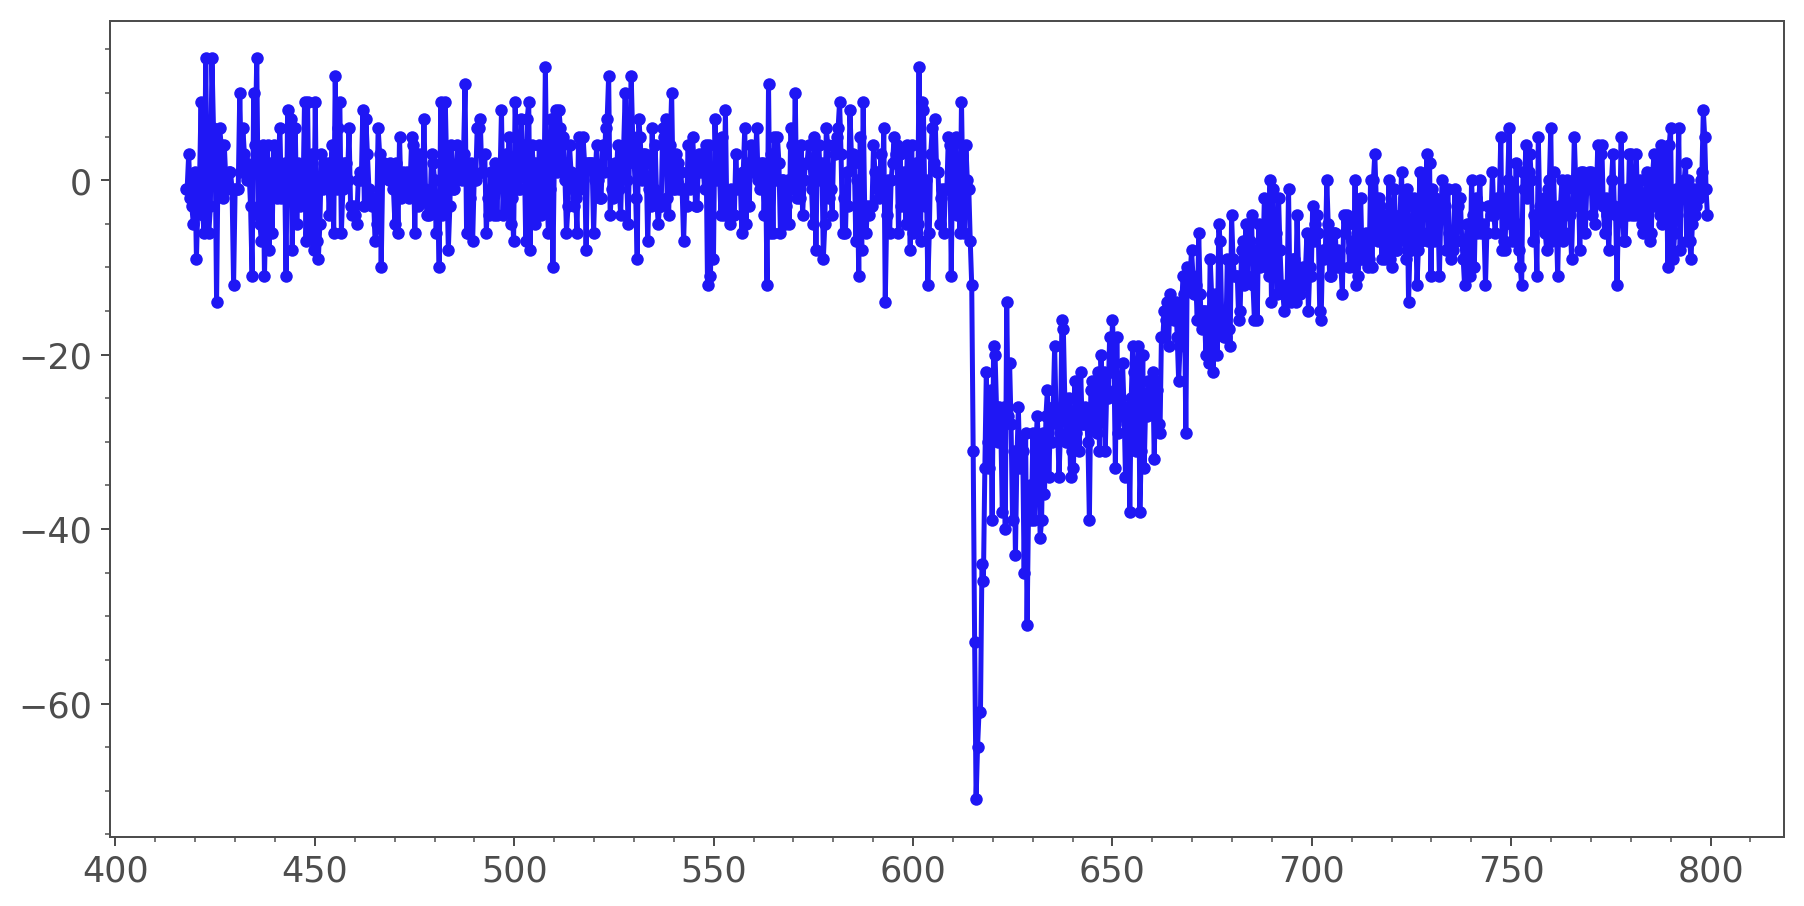

step
poi
Current poi 9
['move', 'optimize', 'spectrum', 'time_trace']
step
Current step: move
_steps ['optimize', 'spectrum', 'time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
move
9
step
Current step: optimize
_steps ['spectrum', 'time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
optimize
step
Current step: spectrum
_steps ['time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
spec
mirror
no filter
step
Current step: time_trace
_steps []
steps ['move', 'optimize', 'spectrum', 'time_trace']
step
poi
Current poi 10
['move', 'optimize', 'spectrum', 'time_trace']
step
Current step: move
_steps ['optimize', 'spectrum', 'time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
move
10
step
Current step: optimize
_steps ['spectrum', 'time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
optimize
step
Current step: spectrum
_steps ['time_trace']
steps ['move', 'optimize', 'spectrum', 'time_trace']
spec
mirror
no filter
step
Cu

In [211]:
plt.plot(lam, spectra_datas_nd[25])
plt.show()

In [181]:
spectra_datas_nd[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [140]:
from matplotlib import pyplot as plt

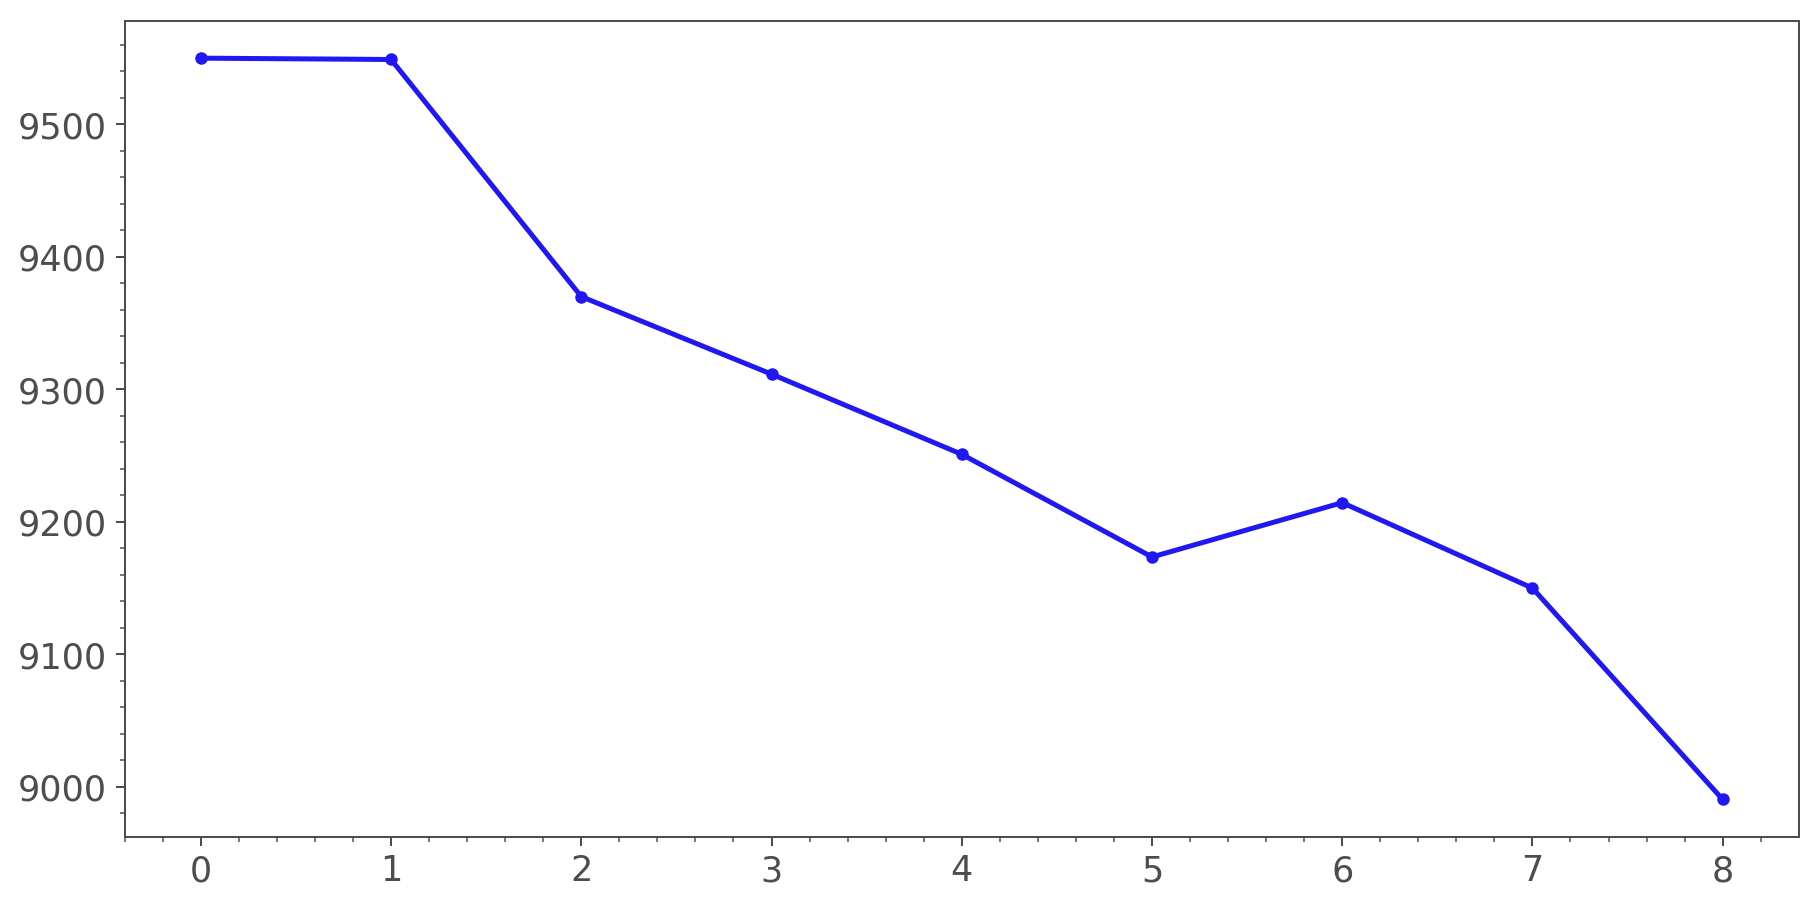

In [149]:
plt.plot(countrate[countrate > 0])
plt.show()

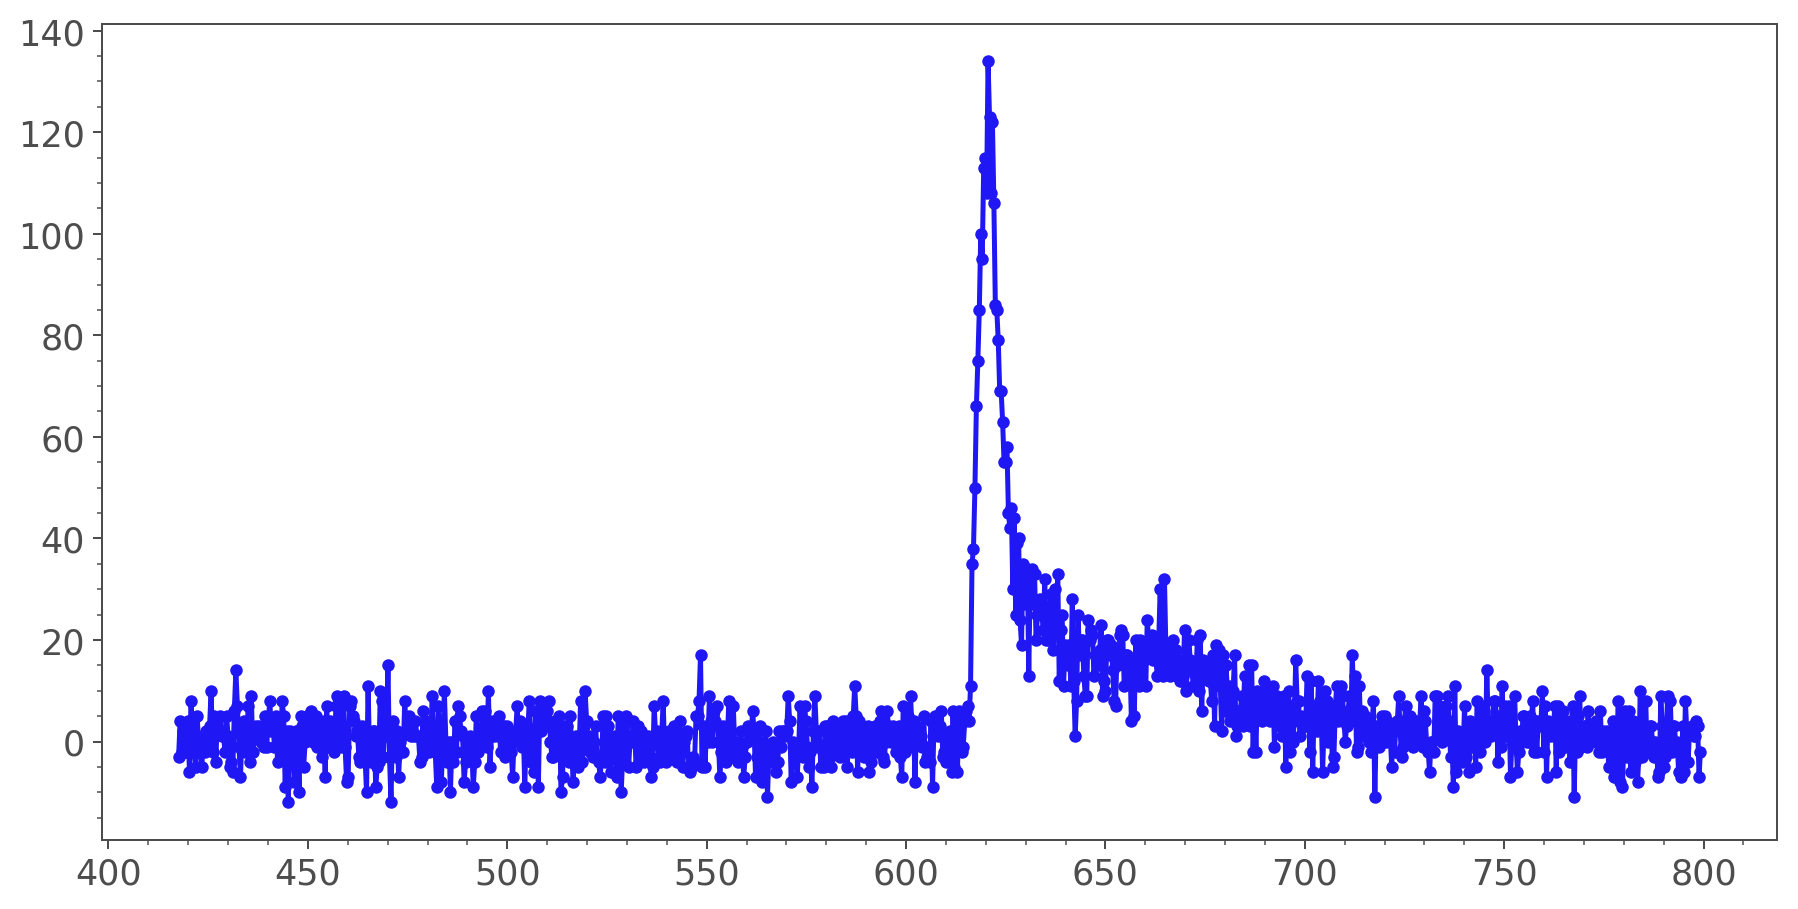

In [141]:
plt.plot(lam, signal - signal_bg)
plt.show()

In [78]:
spectras[1:]

['20220310-1500-22_spectrum_2_575LP_spectrum_inttime_5.dat', '20220310-1501-43_spectrum_3_575LP_spectrum_inttime_5.dat', '20220310-1503-05_spectrum_4_575LP_spectrum_inttime_5.dat']